# Part 1
- Fit a function to u_ret, ret (1D numpy arrays). Only take a subset of points.
- Plot fit, subset and full function.
- Eval the fit on u_ret and call `c_tot_fit = compute_core2B_profile_simple(u_ret, fit(u_ret))` (You may choose better variable names)
- `data_core2b_df = load_exp_data("Core 2B")`
- Plot data_core2b_df["x"], c_tot_fit (same with data_core2b_df["c_tot"])
- Eval and plotting also for `c_diss_fit = compute_core2_btc(u_ret, ret)`

# Part 2
- Let's call the params of the fit the base.
- Explore the parameter space around the base. Suggest several methods to do this and choose the best.
    - Check whether the function has negative derivative everywhere, if not, dismiss.
    - Eval the new function as in Part 1 (no plotting this time) and compute the normalized MSE with the data.


# Coding guidelines
- always use `fig, axs = plt.subplots()` instead of the plt.plot API
- define FAT_GLOBALS for common plotting params (dicts) and stuff


Any questions, is anything unclear?

In [263]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from lib import (
    load_exp_data,
    compute_core2B_profile_simple,
    FinnDir,
    compute_core2_btc,
)

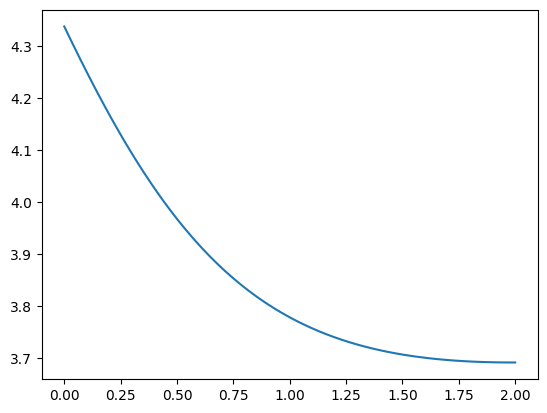

In [264]:
data_core2_df = load_exp_data("Core 2")
data_core2b_df = load_exp_data("Core 2B")

# finn_dir = FinnDir(Path("../data_out/finn/core2"))
finn_dir = FinnDir(Path("../data_out/finn/p3inn_core2_new_multiprocessing/down_0.6"))
finn_params = finn_dir.load_finn_params()
u_ret, ret = finn_dir.best_ret_points
cauchy_mult = finn_params["cauchy_mult"][0]
D_eff = finn_params["D_eff"][0]

c_tot = compute_core2B_profile_simple(u_ret, ret)
c_diss = compute_core2_btc(u_ret, ret, cauchy_mult=cauchy_mult, D_eff=D_eff)
plt.plot(u_ret, ret)
plt.show()

In [265]:
def make_plots(ret_fit, c_tot_fit=None, c_diss_fit=None, axs=None, only_new_data=False):
    if c_tot_fit is None:
        c_tot_fit = compute_core2B_profile_simple(u_ret, ret_fit)
        c_diss_fit = compute_core2_btc(
            u_ret, ret_fit, cauchy_mult=cauchy_mult, D_eff=D_eff
        )

    if axs is None:
        fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
    else:
        fig = plt.gcf()

    axs[0].set_title("Retardation")
    if not only_new_data:
        axs[0].plot(u_ret, ret, label="Full Data")
        # axs[0].plot(u_ret_subset, ret_subset, "k.", zorder=-2, label="Subset")
        axs[0].legend()
    axs[0].plot(u_ret, ret_fit, "k-", alpha=0.4, label="Fit")
    

    axs[1].set_title("BTC")
    if not only_new_data:
        axs[1].scatter(
            data_core2_df["time"], data_core2_df["c_diss"], color="red", alpha=0.3
        )
        axs[1].plot(data_core2_df["time"], c_diss, "-o")
    axs[1].plot(data_core2_df["time"], c_diss_fit, "k-")

    axs[2].set_title("Concentration Profile")
    if not only_new_data:
        axs[2].scatter(
            data_core2b_df["x"], data_core2b_df["c_tot"], color="red", alpha=0.3
        )
        axs[2].plot(data_core2b_df["x"], c_tot, "-o")
    axs[2].plot(data_core2b_df["x"], c_tot_fit, "k-")

    return fig, axs

In [266]:
def model(u, a, b, c):
    return a * np.exp(-b * u) + c
from common import AnalyticRetardation


# model = AnalyticRetardation.linear
# def model(u, smax, Kl):
#     return AnalyticRetardation.langmuir(
#         u, rho_s=finn_params["rho_s"], por=finn_params["por"], smax=smax, Kl=Kl
#     )


def fit_function(u_ret_subset, ret_subset):
    popt, _ = curve_fit(model, u_ret_subset, ret_subset)
    return popt


subset_mask = np.random.choice([True, False], len(u_ret), p=[0.7, 0.3]).astype(bool)
u_ret_subset = u_ret[subset_mask]
ret_subset = ret[subset_mask]

popt = fit_function(u_ret_subset, ret_subset)
ret_base_fit = model(u_ret, *popt)  # Evaluate the fit over full u_ret

c_tot_base_fit = compute_core2B_profile_simple(u_ret, ret_base_fit)
c_diss_base_fit = compute_core2_btc(
    u_ret, ret_base_fit, cauchy_mult=cauchy_mult, D_eff=D_eff
)

print(popt)

[0.70924534 1.65960468 3.65112545]


In [267]:
def compute_mse(y_true, y_pred):
    """Compute the normalized MSE between true values and predicted values."""
    mse = np.mean((y_true - y_pred) ** 2)
    return mse / np.mean(y_true**2)

def pertube_normally(params, sigma):
    return np.random.normal(params, sigma)


def pertube_uniformly(params, quantile):
    return np.random.uniform(params - params * quantile, params + params * quantile)

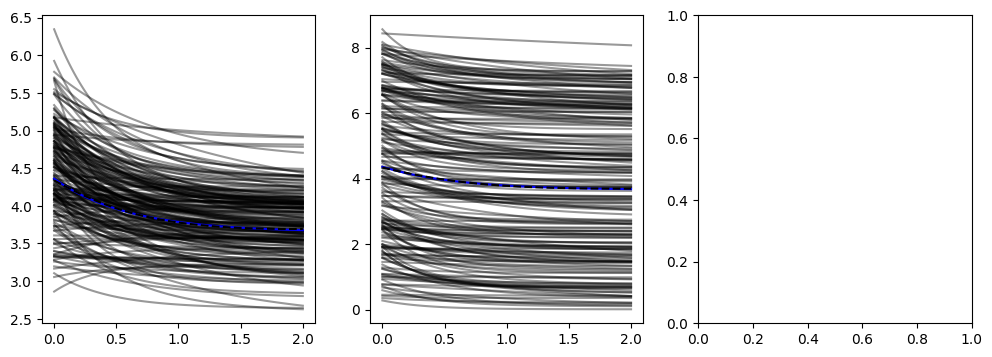

In [272]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for _ in range(200):
    params_a = pertube_normally(popt, 0.5)
    params_b = pertube_uniformly(popt, 1.0)
    axs[0].plot(u_ret, model(u_ret, *params_a), "k-", alpha=0.4)
    axs[1].plot(u_ret, model(u_ret, *params_b), "k-", alpha=0.4)
axs[0].plot(u_ret, ret_base_fit, "b-")
axs[1].plot(u_ret, ret_base_fit, "b-")
axs[0].plot(u_ret, ret, "k--")
axs[1].plot(u_ret, ret, "k--")
# for ax in axs:
#     # ax.set_xlim(0.1, 2.0)
#     ax.set_ylim(3, 5)

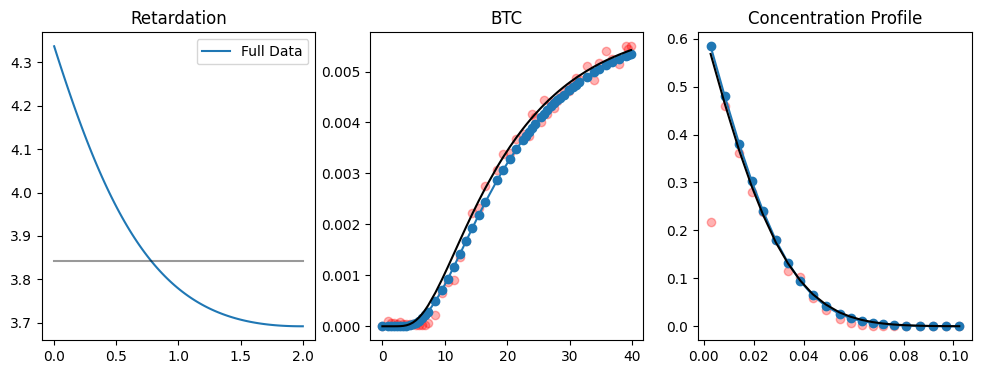

In [210]:
make_plots(ret_base_fit)
plt.show()

In [211]:
print(compute_mse(c_diss, c_diss_base_fit))
print(compute_mse(c_tot, c_tot_base_fit))

0.0022810875
0.0010185977225672682


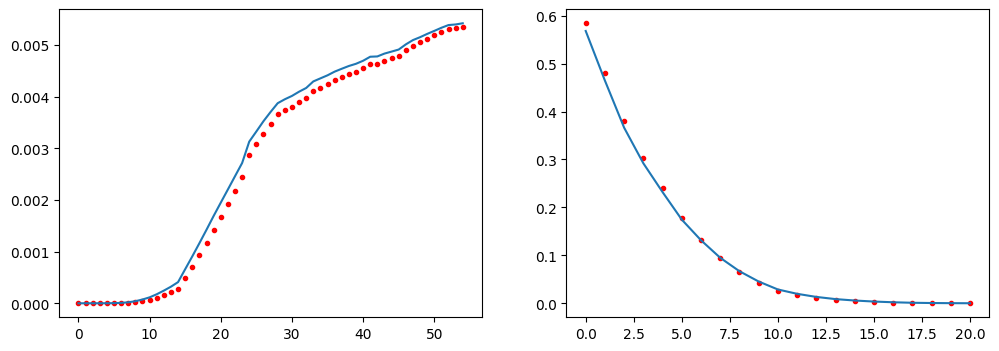

In [212]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(c_diss, "r.")
axs[0].plot(c_diss_base_fit)
axs[1].plot(c_tot, "r.")
axs[1].plot(c_tot_base_fit)

It	MSE_diss	MSE_tot	MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE
High MSE


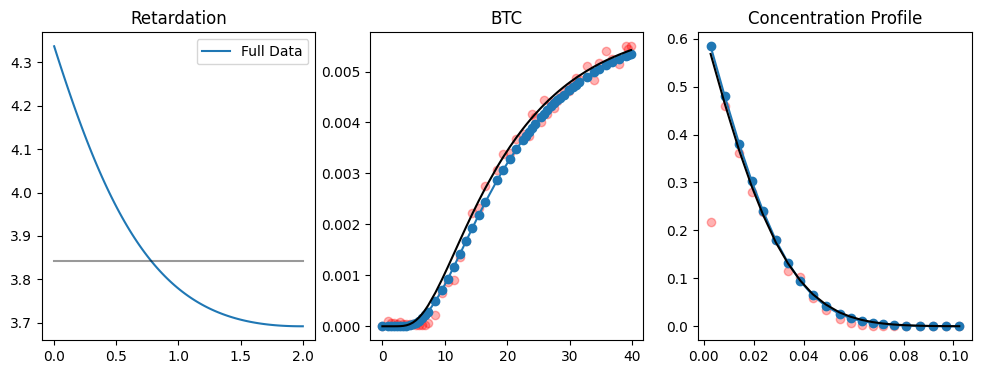

In [236]:
# Parameter Exploration
# Explore parameters around `popt`, checking derivative and calculating MSE for each variation


step = 0.1
n_samples = 200

# Explore the parameter space around popt
best_params = None
best_mse = np.inf

all_fit_rets = []
all_c_diss_fits = []
all_c_tot_fits = []
all_mse_pairs = []
is_sample_good = []


fig, axs = make_plots(ret_base_fit)

print("It\tMSE_diss\tMSE_tot\tMSE")
for i in range(n_samples):
    params = pertube_normally(popt, sigma=0.5)

    ret_fit = model(u_ret, *params)

    if np.any(np.diff(ret_fit) > 0):
        print("Positive Derivative")
        continue

    # If the derivative is negative, compute the profile and MSE
    try:
        c_diss_fit = compute_core2_btc(u_ret, ret_fit, cauchy_mult=cauchy_mult, D_eff=D_eff)
        c_tot_fit = compute_core2B_profile_simple(u_ret, ret_fit)
    except AssertionError:
        print("Bad Retardation")
        continue

    # Compute normalized MSE
    mse_diss = compute_mse(data_core2_df["c_diss"], c_diss_fit)
    mse_tot = compute_mse(data_core2b_df["c_tot"], c_tot_fit)
    mse = (mse_diss + mse_tot) / 2


    all_fit_rets.append(ret_fit)
    all_c_diss_fits.append(c_diss_fit)
    all_c_tot_fits.append(c_tot_fit)
    all_mse_pairs.append((mse_diss, mse_tot))

    if mse_diss > 2.0e-2 or mse_tot > 1.2e-1:
        print("High MSE")
        is_sample_good.append(False)
        continue
    else:
        is_sample_good.append(True)


    # If the MSE is better, update best parameters
    if mse < best_mse:
        best_mse = mse
        best_params = params

    print(f"{i}/{n_samples}\t{mse_diss:.2e}\t{mse_tot:.2e}\t{mse:.2e}")
    make_plots(
        ret_fit=ret_fit,
        c_tot_fit=c_tot_fit,
        c_diss_fit=c_diss_fit,
        only_new_data=True,
        axs=axs,
    )
    # plt.show()

In [237]:
is_sample_good

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [238]:
np.median(all_mse_pairs, axis=0)

array([0.07444589, 0.1970654 ])

In [239]:
for a,b in all_mse_pairs:
    print(f"{a:.2e}, {b:.2e}")

7.77e-03, 1.77e-01
4.31e-01, 2.06e+00
2.80e-01, 1.79e-01
2.13e-02, 4.01e-01
4.41e-02, 5.06e-01
4.35e-02, 5.03e-01
4.59e-01, 2.20e+00
3.43e-02, 1.25e-01
5.01e-02, 1.14e-01
6.74e-02, 1.07e-01
1.00e+00, 2.69e+01
8.26e-02, 1.05e-01
2.62e-03, 2.14e-01
9.48e-02, 7.03e-01
2.09e-01, 1.40e-01
4.01e+23, 2.05e+06
5.67e-01, 2.83e+00
8.15e-02, 1.05e-01
7.00e-03, 1.81e-01
2.06e-02, 1.43e-01


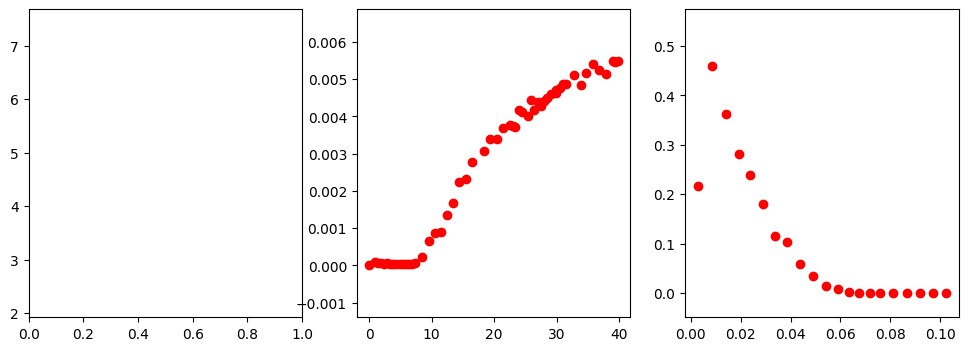

In [262]:
fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for i in range(len(all_mse_pairs)):
    plot_kwargs = dict(label=i)
    # plot_kwargs["color"] = "green" if is_sample_good[i] else "red"
    if all_mse_pairs[i][0] > 2.0e-2 or all_mse_pairs[i][1] > 1.2e-1:
        continue
    axs[0].plot(u_ret, all_fit_rets[i], "-", **plot_kwargs)
    axs[1].plot(data_core2_df["time"], all_c_diss_fits[i], "-", **plot_kwargs)
    axs[2].plot(data_core2b_df["x"], all_c_tot_fits[i], "-", **plot_kwargs)

axs[1].scatter(data_core2_df["time"], data_core2_df["c_diss"], color="red")
axs[2].scatter(data_core2b_df["x"], data_core2b_df["c_tot"], color="red")
axs[0].set_ylim(0.5*ret_base_fit.min(), 2*ret_base_fit.max())
axs[1].set_ylim(-data_core2_df["c_diss"].mean()/2, 1.25*data_core2_df["c_diss"].max())
axs[2].set_ylim(-data_core2b_df["c_tot"].mean()/2, 1.25*data_core2b_df["c_tot"].max())
# plt.legend()
plt.show()